In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

import keras.backend as K


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

from keras.utils import plot_model
from IPython.display import Image

from tensorflow_probability import layers as tfpl

from typhon.retrieval.qrnn.qrnn import QRNN

from sklearn.decomposition import PCA

In [2]:

data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')
data_water=parse.parse('cloudrm_water.dat')

data_all=pd.concat([data_water,data_mixed,data_ice])
data_all=data_all.drop(columns=['Cloud_B01','Clear_B01'])

data_all=hf.dumb_down_surface(data_all) #Create simpler labels for surface description

In [3]:
### Add Instrument noise ###

channel_labels=['Cloud_B02', 'Cloud_B03', 'Cloud_B04', 'Cloud_B05', 'Cloud_B06',
                 'Cloud_B07', 'Cloud_B08', 'Cloud_B09', 'Cloud_B10', 'Cloud_B11',
                 'Cloud_B12','Cloud_B13']

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.003844514228138528
Noise standard deviation for Cloud_B03: 0.0032615477261904763
Noise standard deviation for Cloud_B04: 0.004313791062910798
Noise standard deviation for Cloud_B05: 0.005071532864957266
Noise standard deviation for Cloud_B06: 0.007592370745318352
Noise standard deviation for Cloud_B07: 0.00804061387936508
Noise standard deviation for Cloud_B08: 0.03962543545333333
Noise standard deviation for Cloud_B09: 0.0049796966892720305
Noise standard deviation for Cloud_B10: 0.003921135792982457
Noise standard deviation for Cloud_B11: 0.0016366546253333333
Noise standard deviation for Cloud_B12: 0.0034104471999999997
Noise standard deviation for Cloud_B13: 0.0028364433813333335


In [4]:
input_variables=['Cloud_B02', 'Cloud_B03', 'Cloud_B04', 'Cloud_B05', 'Cloud_B06',
                 'Cloud_B07', 'Cloud_B08', 'Cloud_B09', 'Cloud_B10', 'Cloud_B11',
                'Cloud_B12', 'Cloud_B13', 'Sat_Zenith_Angle','Sun_Zenith_Angle', 'Azimuth_Diff_Angle']
output_variables=   ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06','Clear_B07',
                    'Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

## PCA

In [5]:
data_input_X=data_all[input_variables]
data_Y=data_all[output_variables]

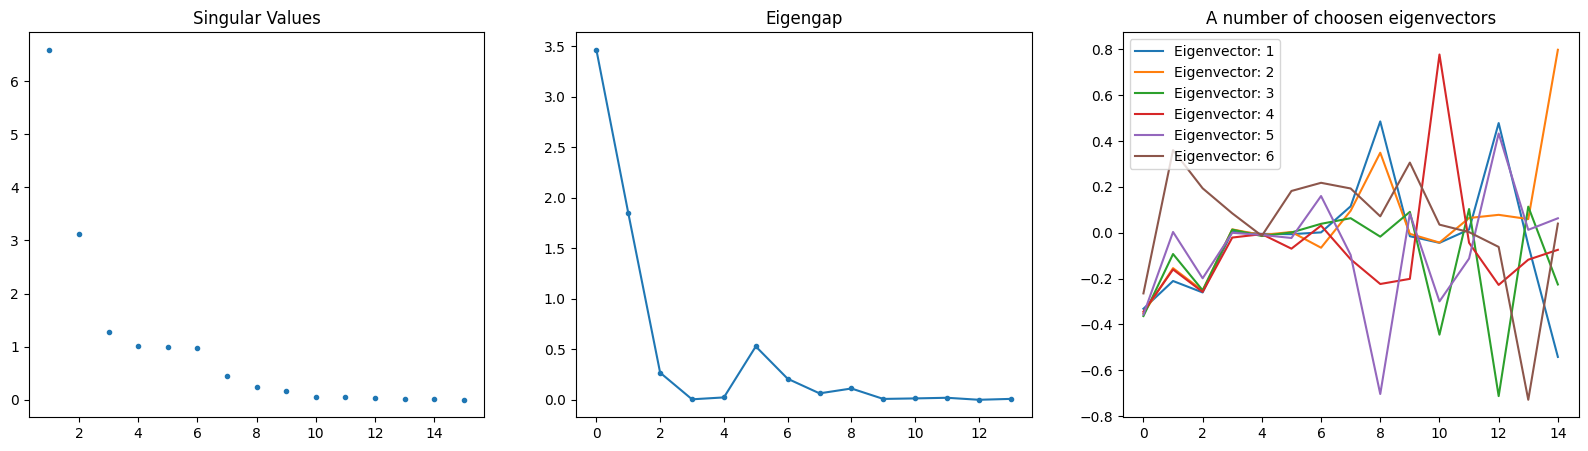

In [6]:
## Check eigenvalues
data_cov=data_input_X.corr()
[U,S,V]=np.linalg.svd(data_cov)
size=np.shape(data_cov)

x=[i+1 for i in range(size[0])]
plt.rcParams["figure.figsize"] = [20, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.plot(x,S,'.')
ax1.title.set_text('Singular Values')


ax2.plot(S[0:-1]-S[1:],'.-')
ax2.title.set_text('Eigengap')

num_eigenvecs=6
ax3.plot(V[:,0:num_eigenvecs])
ax3.title.set_text('A number of choosen eigenvectors')
ax3.legend(["Eigenvector: "+str(i+1) for i in range(num_eigenvecs)])
plt.show()

In [7]:
n_comp=6
pca_input=PCA(n_components=n_comp,svd_solver='full')
data_pca=pca_input.fit_transform(data_input_X)

In [8]:
pca_input_variables=['PCA_channel_'+str(i) for i in range(n_comp)]
df_pca_X=pd.DataFrame(data=data_pca,columns=pca_input_variables)

#Create new dataframe for training, testing
df_pca=pd.DataFrame(data=np.concatenate([df_pca_X.values,data_Y.values],axis=1), columns=np.concatenate([pca_input_variables,output_variables]))


## Train Models

### Non PCA

In [9]:
df=hf.normalise_input_df(data_all,input_variables)
df=hf.add_noise(df,input_variables,sigma=0.001)
num_epochs=10
batch_size=100
model, history_df, X_test,y_test=md.train_simple_model(df,x_labels=input_variables,y_labels=output_variables,split=[0.9,0.05,0.05],epochs=num_epochs,batch_size=batch_size)



Epoch 1/10

1354/1354 [==============================] - 38s 28ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/10
1354/1354 [==============================] - 33s 24ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 3/10
1354/1354 [==============================] - 33s 24ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/10
1354/1354 [==============================] - 41s 30ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 5/10
1354/1354 [==============================] - 40s 30ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 6/10
1354/1354 [==============================] - 40s 30ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 7/10
1354/1354 [==============================] - 39s 29ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 8/10
1354/1354 [=======================

### PCA

In [11]:
### Train from PCA ###

df_pca=hf.normalise_input_df(df_pca,pca_input_variables)
df_pca=hf.add_noise(df_pca,pca_input_variables,sigma=0.001)
num_epochs=10
batch_size=100
model_pca, history_df_pca, X_test_pca,y_test_pca=md.train_simple_model(df_pca,x_labels=pca_input_variables,y_labels=output_variables,split=[0.9,0.05,0.05],epochs=num_epochs,batch_size=batch_size)

Epoch 1/10
1354/1354 [==============================] - 42s 31ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 2/10
1354/1354 [==============================] - 44s 33ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 3/10
1354/1354 [==============================] - 42s 31ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 4/10
1354/1354 [==============================] - 32s 24ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 5/10
1354/1354 [==============================] - 32s 24ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 6/10
1354/1354 [==============================] - 32s 23ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 7/10
1354/1354 [==============================] - 32s 23ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 8/10
1354/1354 [==========================

In [16]:
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print(f"Test mse non PCA: {test_mse}")

235/235 - 3s - loss: 0.0075 - mse: 0.0075 - 3s/epoch - 14ms/step
Test mse non PCA: 0.007488810922950506


In [15]:
test_loss_pca, test_mse_pca = model_pca.evaluate(X_test_pca, y_test_pca, verbose=2)
print(f"Test mse PCA: {test_mse_pca}")

235/235 - 3s - loss: 0.0174 - mse: 0.0174 - 3s/epoch - 12ms/step
Test mse PCA: 0.017387397587299347


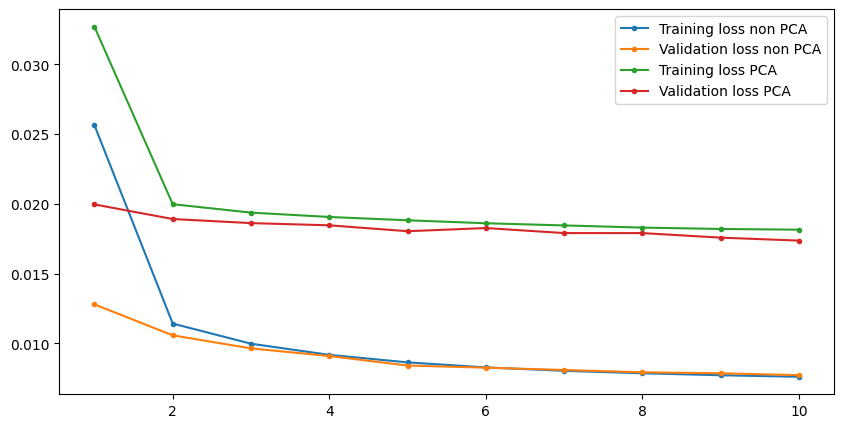

In [33]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(history_df['epoch'],history_df['training_loss'],'.-')
plt.plot(history_df['epoch'],history_df['validation_loss'],'.-')

plt.plot(history_df_pca['epoch'],history_df_pca['training_loss'],'.-')
plt.plot(history_df_pca['epoch'],history_df_pca['validation_loss'],'.-')

plt.legend(['Training loss non PCA','Validation loss non PCA','Training loss PCA','Validation loss PCA'])